In [1]:
import os
import sys
import operator
from pathlib import Path
from dotenv import load_dotenv
from langchain_core.documents import Document
from langchain_teddynote import logging

# 프로젝트 루트를 Python 경로에 추가 (rag 모듈 import를 위해 필요)
project_root = Path().resolve().parent if Path().resolve().name == "LangGraph" else Path().resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"✅ 프로젝트 루트 추가됨: {project_root}")

✅ 프로젝트 루트 추가됨: C:\Users\rkddn\YAI-NLP


In [2]:
#LangSmith 추적 설정
load_dotenv()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "LangSmith_YAI"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

from langchain_teddynote import logging

logging.langsmith("YAI-NLP-Project")

#추적 안 하고 싶을 때
#logging.langsmith("YAI-NLP-Project", set_enable=False)

LangSmith 추적을 시작합니다.
[프로젝트명]
YAI-NLP-Project


In [3]:
from rag.pdf import PDFRetrievalChain

hf_token = os.getenv("HF_API_KEY")
if hf_token:
    os.environ["HF_API_KEY"] = hf_token
else:
    print("⚠️ 경고: HF_API_KEY이 없습니다.")


print("🚀 Hugging Face 기반 체인 생성 시작...")
# 이렇게 써도 프로젝트 data/testdata.pdf 로 해석됨
pdf = PDFRetrievalChain(["nlp.pdf"]).create_chain()
print("✅ 체인 생성 완료!")

pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

🚀 Hugging Face 기반 체인 생성 시작...


Could not get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could not get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could not get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could not get FontBBox from font descriptor because None cannot be parsed as 4 floats


✅ 체인 생성 완료!


In [4]:
search_result = pdf.retriever.invoke("닷-프로덕트 어텐션에 대해 설명해주세요")
search_result

[Document(id='8e9e73be-de00-41ed-9504-fb22d0d0b2fc', metadata={'source': 'nlp.pdf', 'file_path': 'nlp.pdf', 'page': 1, 'total_pages': 7, 'Creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36', 'Producer': 'Skia/PDF m118', 'CreationDate': "D:20231103094424+00'00'", 'ModDate': "D:20231103094424+00'00'"}, page_content='3. 닷-프로덕트 어텐션(Dot-Product Attention)\n어텐션은 다양한 종류가 있는데 그 중에서도 가장 수식적으로 이해하기 쉽게 수식을 적용한 닷-프로덕트 어텐션(Dot-Product\nAttention)을 통해 어텐션을 이해해봅시다. seq2seq에서 사용되는 어텐션 중에서 닷-프로덕트 어텐션과 다른 어텐션의 차이는 주로\n중간 수식의 차이로 메커니즘 자체는 거의 유사합니다.'),
 Document(id='13ab45af-8b56-43fa-a3d3-54cd350eba14', metadata={'source': 'nlp.pdf', 'file_path': 'nlp.pdf', 'page': 6, 'total_pages': 7, 'Creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36', 'Producer': 'Skia/PDF m118', 'CreationDate': "D:20231103094424+00'00'", 'ModDate': "D:20231103094424+00'00'"}, page_content='지

In [5]:
answer = pdf_chain.invoke(
    {
        "question": "닷-프로덕트 어텐션에 대해 설명해주세요. 반드시 한글로 설명하세요요",
        "context": search_result,
        "chat_history": [],
    }
)
print(answer)

닷-프로덕트 어텐션(Dot-Product Attention)은 어텐션 메커니즘 중 하나로, 어텐션 스코어를 구하는 방법이 내적(점곱)인 어텐션입니다. 이 어텐션은 Query, Keys, Values를 사용하여 어텐션 스코어를 계산합니다.

Query(Q)는 디코더의 현재 시점의 은닉 상태, Keys(K)는 인코더의 모든 시점의 은닉 상태, Values(V)는 인코더의 모든 시점의 은닉 상태를 의미합니다. 닷-프로덕트 어텐션에서는 Query와 Keys를 내적으로 곱하여 어텐션 스코어를 계산합니다.

어텐션 스코어를 계산한 후, 어텐션 분포를 구하기 위해 소프트맥스 함수를 적용합니다. 어텐션 분포는 각 시점의 은닉 상태가 현재 시점의 은닉 상태와 얼마나 관련이 있는지 나타내는 값입니다.

닷-프로덕트 어텐션은 어텐션 메커니즘의 기본적인 형태로, 다른 어텐션 메커니즘과 비교하여 중간 수식의 차이만 있을 뿐 메커니즘 자체는 유사합니다.


In [6]:
from typing import TypedDict, Annotated, List
from langgraph.graph.message import add_messages

class GraphState(TypedDict):
    #policy: Annotated[str, "Policy"] #누적됨
    question: Annotated[str, "Question"]
    context: Annotated[str, "Context"]
    answer: Annotated[str, "Answer"]
    messages: Annotated[list, add_messages] #메시지(누적되는 list)
    relevance: Annotated[str, "Relevance"]

    """
    context 구성요소
    1. 챗봇 대화 기록
    2. 웹 검색 결과
    3. 시스템 프롬프트
    4. [POLICY]
    5. 사용자 질문
    6. 최근에 retrieve 한 내용


    context내에서 처리 or retrieve?
    -> 프롬프트 내에 연관성이 있는 맥락이 있는지 서치하는 LLM 모델 필요할 듯
    """
    

<h3>노드 정의</h3>

Relevance 체크용 모델

In [7]:
from huggingface_hub import login
login(token=os.getenv("HF_API_KEY"))

In [8]:
#일단 Relevance용 모델 정의
from transformers import pipeline
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint, HuggingFacePipeline

hf_llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.1-8B-Instruct",
    task="conversational",
    temperature=0.0,
    max_new_tokens=512,
)

chat_hf = ChatHuggingFace(llm=hf_llm)
# pipe = pipeline(
#     "text-generation",
#     model="Qwen/Qwen2.5-7B-Instruct",
#     device="auto", #cpu or gpu
#     max_new_tokens=512,
#     temperature=0.3,
# )

# hf_local = HuggingFacePipeline(pipeline=pipe)
# chat_hf = ChatHuggingFace(llm=hf_local)

저장위치: C:\Users\rkddn\.cache\huggingface\hub\

In [9]:
from rag.utils import format_docs
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_teddynote.messages import messages_to_history

"""===========Conditional Edge로 사용할 함수들=========="""
def retrieve_or_not(state: GraphState) -> str:
    #retrieve 여부 결정
    context = state["context"]
    question = state["question"]
    """
    context 내에 question과 유사한 내용이 있으면
    """
    if "유사한 내용" in context:
        return "retrieve"
    else:
        return "not retrieve"

def upload_to_vectorDB(state: GraphState) -> bool:
    if "Search 함수에서 찾은 내용을 -> 벡터DB에 업로드 성공":
        return True
    else:
        return False

def multiturn_chat_to_vectorDB(state: GraphState) -> bool:
    if "컨텍스트가 너무 길어져서 -> 벡터DB에 업로드 성공":
        return True
    else:
        return False
    
"""===========노드 정의=========="""
def retrieve(state: GraphState) -> GraphState:
    latest_question = state["question"]
    retrieved_docs = pdf_retriever.invoke(latest_question)
    formatted_docs = format_docs(retrieved_docs)
    return GraphState(context=formatted_docs)
    #same as return {"context": formatted_docs}

def llm_answer(state: GraphState) -> GraphState:
    #policy = state["policy"]
    context = state["context"]
    latest_question = state["question"]

    chat_history = messages_to_history(state["messages"]) if state["messages"] else []
    # 만약 문자열이 반환되면 빈 리스트로 대체
    if not isinstance(chat_history, list):
        chat_history = []

    #이번에 새로 들어온 내용, 컨텍스트, 챗 히스토리 기반 답변 생성
    response = pdf_chain.invoke(
        {   
            #"policy": policy,
            "question": latest_question,
            "context": context,
            "chat_history": chat_history,
        }
    )

    return GraphState(
        answer=response,
        messages=[("user", latest_question), ("assistant", response)],
    )

Relevance Check Node (question-retrieve)

In [10]:
# #질문과 검색 간의 관련성 평가
# def relevance_check(state: GraphState) -> GraphState:
#     question_retrieval_relevant = GroundednessChecker(
#         llm = chat_hf,
#         target="question-retrieval",  #<-------검색된 문서와 질문의 관련성 평가
#     ).create()

#     #관련성 체크 실행(Yes or No)
#     response = question_retrieval_relevant.invoke(
#         {
#             "question": state["question"],
#             "context": state["context"],
#         }
#     )

#     print("==== [RELEVANCE CHECK] ====")
#     print(response.score)

#     return {"relevance": response.score}

def is_relevant(state: GraphState) -> str:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"

In [11]:
import json
import re

def relevance_check(state: GraphState) -> GraphState:
    prompt = f"""
You are a grader assessing whether a retrieved document is relevant to the given question.
Return ONLY valid JSON like: {{"score": "yes"}} or {{"score": "no"}}.

Question:
{state["question"]}

Retrieved document:
{state["context"]}
""".strip()

    # HF 모델 호출
    response = chat_hf.invoke(prompt)

    # ChatHuggingFace는 보통 response.content에 텍스트가 들어있음
    text = response.content.strip()

    # JSON만 추출 (모델이 앞뒤에 텍스트를 섞는 경우 대비)
    match = re.search(r"\{.*\}", text, re.DOTALL)
    if match:
        text = match.group(0)

    try:
        data = json.loads(text)
        score = data.get("score", "no").lower()
    except Exception:
        score = "no"

    if score not in ["yes", "no"]:
        score = "no"

    print("==== [RELEVANCE CHECK] ====")
    print(score)

    return {"relevance": score}

Web Search Node

In [12]:
from langchain_teddynote.tools.tavily import TavilySearch

def web_search(state: GraphState) -> GraphState:
        
    tavily_tool = TavilySearch()

    search_query = "2024년도 노벨 문학상 수상자는?"
    #search_query = state["question"]
    #state에 key값으로 max_results 추가해서 동적으로 조정 가능
    search_result = tavily_tool.search(
        query=search_query,
        topic="general",
        max_results=3,
        format_output=True,
        #include_domains=["news.naver.com"],
    )

    print(search_result)
    """
    +++++ 웹에서 서치한 결과를 바로 VectorDB에 저장할 것인가?
    call write_to_vectorDB(to_write=search_result)
    """
    return GraphState(context=search_result)


<h3>그래프 생성</h3>

In [13]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

"""
conditional_edges
    retrieve or not으로 
    retrieve함수 or llm_answer함수
"""

workflow.add_node("retrieve", retrieve)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("web_search", web_search)


workflow.add_edge("retrieve", "relevance_check")

workflow.add_conditional_edges(
    "relevance_check",
    is_relevant,
    {
        "relevant": "llm_answer",
        "not relevant": "web_search",
    },
)

workflow.add_edge("web_search", "llm_answer")
workflow.add_edge("llm_answer", END)


#이거 바까야됨
workflow.set_entry_point("retrieve")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

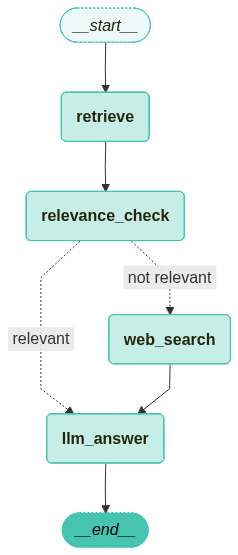

In [14]:
from langchain_teddynote.graphs import visualize_graph
visualize_graph(app)

<h3>그래프 실행</h3>

In [15]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, random_uuid

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

inputs = GraphState(question="2024년 노벨문학상 수상자는??")

invoke_graph(app, inputs, config, node_names=["relevance_check", "llm_answer"])

==== [RELEVANCE CHECK] ====
no

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no
['<document><title>2024년 노벨문학상 수상자는 한강...윤 대통령, “국가적 경사”</title><url>https://www.tongilnews.com/news/articleView.html?idxno=211772</url><content>2024년 노벨문학상 수상자는 한강...윤 대통령, “국가적 경사”. ### 2024년 노벨문학상 수상자는 한강...윤 대통령, “국가적 경사”. 2024년 노벨문학상 수상자는 한국인 소설가 한강(53)이었다. 10일(현지시간) 스웨덴 한림원은 “역사의 트라우마에 맞서고 인간의 취약성을 폭로하는 그녀의 강력한 시적 산문”을 선정 이유로 들었다. 2000년 김대중 대통령(평화상)에 이어 두 번째 한국인 노벨상 수상자다. 라오스를 방문 중인 윤석열 대통령은 10일 밤 SNS 메시지를 통해 “한강 작가님의 2024년 노벨문학상 수상을 진심으로 축하드린다”며, “대한민국 문학사상 위대한 업적이자 온 국민이 기뻐할 국가적 경사”라고 지적했다. “‘역사적 트라우마에 맞서고 인간 삶의 연약함을 드러내는 강렬한 시적 산문’이라는 한림원의 선정 사유처럼, 작가님께서는 우리 현대사의 아픈 상처를 위대한 문학작품으로 승화시키셨다”면서 “한국문학의 가치를 높이신 작가님께 존경의 마음을 전한다”고 했다. “한강 작가는 맨부커상을 비롯한 많은 국내외 문학상을 수상한 자랑스러운 문학가인 동시에 많은 국민에게 사랑받는 작가”이며 “5.18 민주화운동을 다룬 <소년이 온다>, 제주 4.3 항쟁을 다룬 <작별하지 않는다> 등 우리 역사에 남은 트라우마에 맞선 강렬한 산문으로 전 세계인의 큰 사랑을 받았다”고 평가했다. “삶의 아름다움을 노래하면서도, 그 상처를 정면으로 대면해온 한 작가의 문학이 세계에 우뚝 솟은 모습은 

In [16]:
from langchain_teddynote.messages import stream_graph
stream_graph(app, inputs, config)


🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score": "no"}==== [RELEVANCE CHECK] ====
no
['<document><title>2024년 노벨문학상 수상자는 한강...윤 대통령, “국가적 경사”</title><url>https://www.tongilnews.com/news/articleView.html?idxno=211772</url><content>2024년 노벨문학상 수상자는 한강...윤 대통령, “국가적 경사”. ### 2024년 노벨문학상 수상자는 한강...윤 대통령, “국가적 경사”. 2024년 노벨문학상 수상자는 한국인 소설가 한강(53)이었다. 10일(현지시간) 스웨덴 한림원은 “역사의 트라우마에 맞서고 인간의 취약성을 폭로하는 그녀의 강력한 시적 산문”을 선정 이유로 들었다. 2000년 김대중 대통령(평화상)에 이어 두 번째 한국인 노벨상 수상자다. 라오스를 방문 중인 윤석열 대통령은 10일 밤 SNS 메시지를 통해 “한강 작가님의 2024년 노벨문학상 수상을 진심으로 축하드린다”며, “대한민국 문학사상 위대한 업적이자 온 국민이 기뻐할 국가적 경사”라고 지적했다. “‘역사적 트라우마에 맞서고 인간 삶의 연약함을 드러내는 강렬한 시적 산문’이라는 한림원의 선정 사유처럼, 작가님께서는 우리 현대사의 아픈 상처를 위대한 문학작품으로 승화시키셨다”면서 “한국문학의 가치를 높이신 작가님께 존경의 마음을 전한다”고 했다. “한강 작가는 맨부커상을 비롯한 많은 국내외 문학상을 수상한 자랑스러운 문학가인 동시에 많은 국민에게 사랑받는 작가”이며 “5.18 민주화운동을 다룬 <소년이 온다>, 제주 4.3 항쟁을 다룬 <작별하지 않는다> 등 우리 역사에 남은 트라우마에 맞선 강렬한 산문으로 전 세계인의 큰 사랑을 받았다”고 평가했다. “삶의 아름다움을 노래하면서도, 그 상처를 정면으로 대면해온 한 작가의 문학이 세계에 우뚝 솟은 모습은

In [17]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: 2024년 노벨문학상 수상자는??
Answer:
2024년 노벨문학상 수상자는 한강입니다.


In [ ]:
# test test test